In [1]:
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

# helpful tools
# import mc_tools
from mc_tools import *

In [2]:
fashion_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

fashionData = fashion_data.data.numpy()

more pixels each pixel is weighted less heaviely
errors also don't matter as much

In [3]:
def test_one_img(data, p):
    # mask it
    masked_image, omega = mask_image(data, p)
    # try to unmask it with sdp
    unmasked = mc_solver(masked_image, omega)
    return data, masked_image, unmasked

def show_img_triple(orig, masked, unmasked, i, axs):
    axs[i,0].set_title("Original")
    axs[i,0].imshow(orig, cmap="gray")
    axs[i,1].set_title("Masked")
    axs[i,1].imshow(masked, cmap="gray")
    axs[i,2].set_title("Unmasked")
    axs[i,2].imshow(unmasked,cmap="gray")

def test_and_plot_one_example(data, masked, unmasked, p, s=None):
    _, masked, unmasked = test_one_img(data, p)
    fig, axs = plt.subplots(1,3)
    plt.figure(figsize=(10, 10))
    axs[0].set_title("Original")
    axs[0].imshow(data, cmap="gray")
    axs[1].set_title("Masked")
    axs[1].imshow(masked, cmap="gray")
    axs[2].set_title("Unmasked")
    axs[2].imshow(unmasked,cmap="gray")
    if s is not None:
        fig.suptitle(s)

def plot_colored_example(data, masked, unmasked, p, s=None):
    fig, axs = plt.subplots(1,3)
    plt.figure(figsize=(10, 10))
    axs[0].set_title("Original")
    axs[0].imshow(data, cmap="gray")
    axs[1].set_title("Masked")
    axs[1].imshow(masked, cmap="gray")
    axs[2].set_title("Unmasked")
    axs[2].imshow(unmasked,cmap="gray")
    if s is not None:
        fig.suptitle(s)

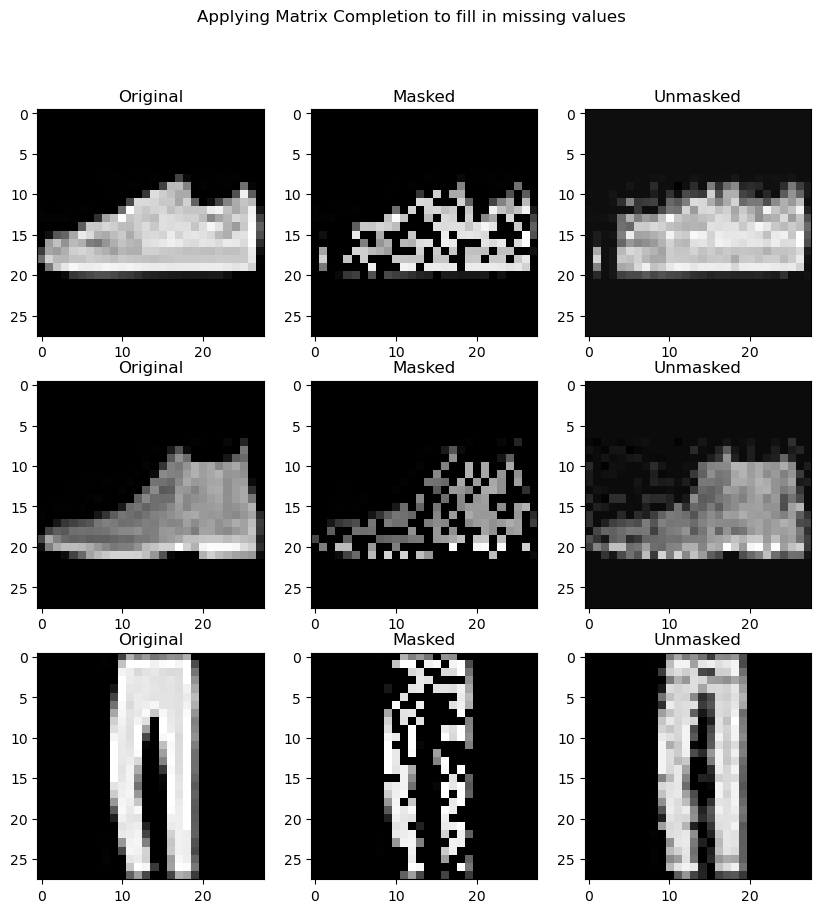

<Figure size 1000x1000 with 0 Axes>

In [4]:
# percent of points to remove 
p = .45

num_img = 3
rows, cols = num_img, 3
fig, axs = plt.subplots(rows,cols, figsize=(10,10))
figure = plt.figure(figsize=(10, 10))
fig.suptitle("Applying Matrix Completion to fill in missing values")
for i in range(num_img):
    # pick a random image in fashionData
    sample = np.random.randint(0,fashionData.shape[1])
    _, masked_image, im = test_one_img(fashionData[sample], p)
    show_img_triple(fashionData[sample], masked_image, im, i, axs)
plt.show()

(68, 78, 3)


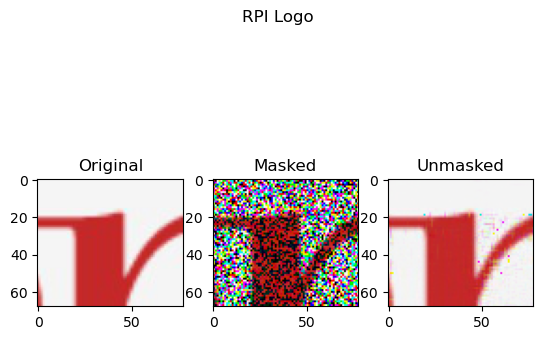

<Figure size 1000x1000 with 0 Axes>

In [5]:
rpi_logo = plt.imread('data/imgs/color.jpg')
r, g, b = rpi_logo[:, :, 0], rpi_logo[:, :, 1], rpi_logo[:, :, 2]
# rpi_logo = 0.299 * r + 0.587 * g + 0.114 * b
print(rpi_logo.shape)
p = .45
    
_, masked_r, unmasked_r = test_one_img(r, p)
_, masked_g, unmasked_g = test_one_img(g, p)
_, masked_b, unmasked_b = test_one_img(b, p)

masked = np.zeros_like(rpi_logo)
unmasked = np.zeros_like(rpi_logo)

def add_color(r,g,b, orig):
    M = np.zeros_like(orig)
    M[:, :, 0] = r
    M[:, :, 1] = g 
    M[:, :, 2] = b 
    return M

masked = add_color(masked_r, masked_g, masked_b, rpi_logo)
unmasked = add_color(unmasked_r, unmasked_g, unmasked_b, rpi_logo)

plot_colored_example(rpi_logo,masked,unmasked, p, "RPI Logo")
plt.show()